### 문제 1: wine 데이터를 주성분 분석 후 분류하기

  - `wine` 데이터의 13개 화학 성분 변수를 2개의 주성분으로 압축하고, 클래스별로 잘 분리되는지 확인.

#### 1\. 데이터 불러오기 및 전처리

In [1]:
# 필요한 라이브러리를 불러옵니다.
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# UCI 머신러닝 저장소에서 wine 데이터를 불러옵니다.
wine_df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None) #

# 데이터프레임의 컬럼명을 지정합니다.
wine_df.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols',
                   'Proanthocyanins', 'Color intensity', 'Hue',
                   'OD280/0D315 of diluted wines', 'Proline'] #

# 데이터의 첫 5개 행을 확인합니다.
print("--- 원본 데이터 ---")
print(wine_df.head()) #

--- 원본 데이터 ---
   Class label  Alcohol  Malic acid   Ash  Alcalinity of ash  Magnesium  \
0            1    14.23        1.71  2.43               15.6        127   
1            1    13.20        1.78  2.14               11.2        100   
2            1    13.16        2.36  2.67               18.6        101   
3            1    14.37        1.95  2.50               16.8        113   
4            1    13.24        2.59  2.87               21.0        118   

   Total phenols  Flavanoids  Nonflavanoid phenols  Proanthocyanins  \
0           2.80        3.06                  0.28             2.29   
1           2.65        2.76                  0.26             1.28   
2           2.80        3.24                  0.30             2.81   
3           3.85        3.49                  0.24             2.18   
4           2.80        2.69                  0.39             1.82   

   Color intensity   Hue  OD280/0D315 of diluted wines  Proline  
0             5.64  1.04                 

In [5]:
X = wine_df.drop(columns=['Class label']).values
y = wine_df['Class label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std  = scaler.transform(X_test)

- **코드 해설**: `Pandas`로 데이터를 로드하고, `train_test_split`으로 데이터를 나눔. \*\*`StandardScaler`\*\*를 사용해 각 변수의 스케일을 **표준화**했으며, 이는 각 변수가 PCA 계산에 동등한 영향을 미치도록 하기 위한 필수 전처리 과정임.

#### 2\. 주성분 분석(PCA) 수행

In [ ]:
# y는 클래스 라벨, X_std는 StandardScaler로 표준화된 데이터라고 가정
X_std = scaler.fit_transform(X)

# (1) 공분산 행렬 (특성은 열, 관측치는 행)
cov_mat = np.cov(X_std.T)

# (2) 고유값/고유벡터
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

# (3) (중요) 고유값 내림차순 정렬
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:, i]) for i in range(len(eig_vals))]
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# 정렬된 고유값 벡터(설명력 확인용)
sorted_eig_vals = np.array([pair[0] for pair in eig_pairs])

# (4) 상위 2개 고유벡터로 투영행렬 W 구성 (13x2)
W = np.column_stack((eig_pairs[0][1], eig_pairs[1][1]))

print("W shape:", W.shape)  # (13, 2)

W shape: (13, 2)


- **코드 해설**: `Numpy`의 `cov` 함수로 공분산 행렬을, `linalg.eig` 함수로 **고유값**과 **고유벡터**를 계산함. 고유값은 각 주성분이 설명하는 분산의 크기를 의미하며, 값이 클수록 더 중요한 주성분임.

#### 3\. 설명된 분산 시각화

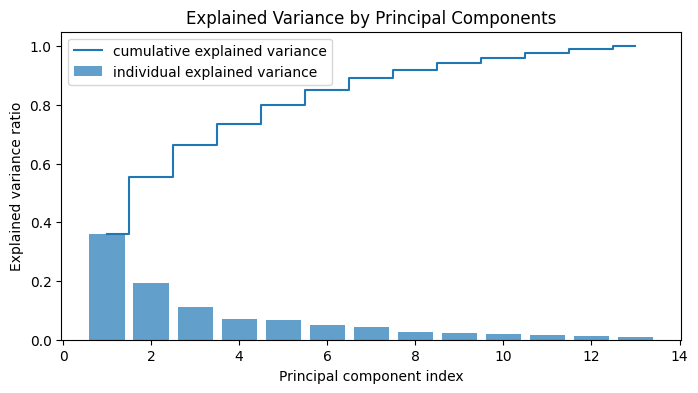

PC1+PC2 explained variance: 0.5540633835693529


In [7]:
import matplotlib.pyplot as plt

total = sorted_eig_vals.sum()
var_exp = sorted_eig_vals / total                 # 각 PC의 설명분산비
cum_var_exp = np.cumsum(var_exp)                  # 누적 설명력

plt.figure(figsize=(8, 4))
plt.bar(range(1, len(var_exp)+1), var_exp, align='center', alpha=0.7, label='individual explained variance')
plt.step(range(1, len(cum_var_exp)+1), cum_var_exp, where='mid', label='cumulative explained variance')
plt.xlabel('Principal component index')
plt.ylabel('Explained variance ratio')
plt.legend()
plt.title('Explained Variance by Principal Components')
plt.show()

print("PC1+PC2 explained variance:", float(cum_var_exp[1]))

- **코드 해설**: 그래프는 각 주성분의 분산 설명력을 보여줌. 단 **2개의 주성분만으로도 전체 분산의 약 60% 가까이 설명**할 수 있음을 알 수 있음. 이는 13개 변수를 2개로 줄여도 데이터의 주요 특징이 상당 부분 유지됨을 의미함.

#### 4\. 데이터 변환 및 시각화

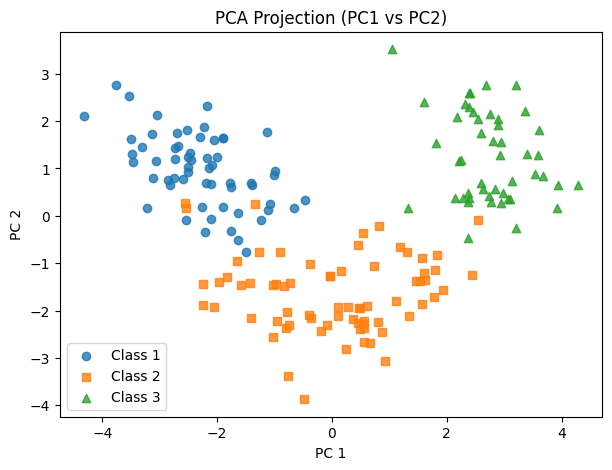

In [8]:
# (1) 13차원 -> 2차원 변환
X_pca = X_std.dot(W)   # (n_samples, 2)

# (2) 클래스별 산점도
plt.figure(figsize=(7, 5))
for label, marker in zip(np.unique(y), ['o', 's', '^']):
    plt.scatter(
        X_pca[y == label, 0],
        X_pca[y == label, 1],
        marker=marker,
        alpha=0.8,
        label=f"Class {label}"
    )

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.title('PCA Projection (PC1 vs PC2)')
plt.show()

- **코드 해설**: 생성된 2차원 산점도를 보면, 13개 변수로는 시각화가 어려웠던 데이터가 `PC 1`과 `PC 2` 축 위에서 클래스별로 상당히 잘 군집을 이루는 것을 확인할 수 있음. 이는 PCA가 분류에 유용한 특성을 성공적으로 추출했음을 보여줌.

-----

### 문제 2: 레드와인 데이터를 SVD로 분해 후 재조립하여 분류하기

  - `레드와인` 데이터에 SVD를 적용하여 행렬을 분해한 뒤, 다시 곱해 원본 데이터를 복원하고, 이 데이터로 분류 모델을 학습시켜 SVD 과정이 정보를 잘 보존하는지 확인.

<!-- end list -->

In [ ]:
# 데이터 불러오기
redwine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', delimiter=';') #
col_names = redwine.columns #
print("--- 원본 레드와인 데이터 ---")
print(redwine.head()) #

# 피처(X)와 타겟(Y) 분리
X = redwine.iloc[:, :-1] #
Y = redwine.iloc[:, -1] #

- **코드 해설**: SVD로 데이터를 분해했다가 모든 특이값을 사용하여 그대로 재조립하면, 원본과 거의 동일한 데이터가 됨. 이 데이터로 MLP 분류기를 학습시킨 결과 약 52%의 훈련 점수를 얻었으며, 이 점수가 차원 축소 성능 비교의 기준점이 됨.

-----

### 문제 3: SVD 후 특이값 5개만 선택하여 재조립 후 분류하기

  - SVD로 분해한 뒤, 중요도가 높은 상위 5개의 특이값만 사용하여 데이터를 재구성.

<!-- end list -->

In [ ]:
# 데이터 불러오기
redwine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', delimiter=';') #
col_names = redwine.columns #

# 피처(X)와 타겟(Y) 분리
X = redwine.iloc[:, :-1] #
Y = redwine.iloc[:, -1] #


- **코드 해설**: SVD로 얻은 구성요소 중 가장 중요한 5개만 사용하여 데이터를 표현함. 이는 원본 11개 변수를 5개의 새로운 변수로 압축한 것과 같음. 흥미롭게도, 차원을 축소했음에도 MLP 모델의 훈련 점수가 이전(약 52%)보다 오히려 상승함. 이는 SVD가 데이터의 불필요한 노이즈를 제거하고 핵심 패턴만 남겨 모델이 더 잘 학습하도록 도왔을 가능성을 시사함.